In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sympy import *

In [2]:
# user defined parameters
u = 2   # velocity
Tf = 2  # final time
ax = -1; bx = 1
sigma = 1/8
#qinit = lambda x: np.exp(-(x/(2*sigma))**2)
qinit = lambda x : np.sin(2*np.pi*x)

# function f(q(x,t)) = u*q(x,t)

fe = lambda q: u*q


In [3]:
N = 3 # order of the legendre polynomial
Q = N+1
a = 0.1  # CFL number

In [4]:
def Lobatto_deriv(Q, x):
    F = [] # array containing the polynomials
    dF = []
    ddF = []


    f0 = 1; F.append(f0)  # first polynomial
    df0 = 0; dF.append(df0)
    f1 = x; F.append(f1)  # second polynomial
    df1 = 1; dF.append(df1)
    ddF = [0,0]

    B = []
    dB = []


    for i in range(2, Q+1):
        fi = ((2*i-1)/i)*x*F[i-1] - ((i-1)/i)*F[i-2]  # iteration of the polynomials
        dfi = i*F[i-1] + x*dF[i-1]                    # first derivative
        F.append(fi)
        dF.append(dfi)
        ddfi = (i+1.0)*dF[i-1] + x*ddF[i-1]           # second derivative
        ddF.append(ddfi)

        bi = (1.0-x**2)*dF[i-1]                       # lobatto polynomial
        dbi = -2.0*x*dF[i-1] + (1.0-x**2)*ddF[i-1]    # derivative of lobatto polynomial
        B.append(bi)
        dB.append(dbi)
        
    return B[-1], dB[-1]

In [5]:
def Legendre_deriv(Q, x):
    L = [] # array containing the polynomials
    dL = []


    f0 = 1; L.append(f0)  # first polynomial
    df0 = 0; dL.append(df0)
    f1 = x; L.append(f1)  # second polynomial
    df1 = 1; dL.append(df1)
    

    for i in range(2, Q+1):
        fi = ((2*i-1)/i)*x*L[i-1] - ((i-1)/i)*L[i-2]  # iteration of the polynomials
        dfi = i*L[i-1] + x*dL[i-1]
        L.append(fi)
        dL.append(dfi)
        
    return L[-1], dL[-1]

In [6]:
def Lobatto_p(Q):
    X = []  # Array that contains legendre points
    K = 100  # Order of approximation of Newton method
    e = 10**(-20) #error
    for i in range(0, Q+1):
        xi0 = np.cos(((2*i+1)/(2*Q+2))*np.pi)   # Chebchev points
        

        xik = xi0

        for k in range(0, K):
            out1, out2 = Lobatto_deriv(Q+1, xik)
            xikk = xik - out1/out2   # approximation of the solution using Newton

            if abs(xikk-xik) < e:

                break

            xik = xikk

        X.append(xikk)
    return X

In [7]:
def LagrangeBasis(N, i, xl, Xr):
    
    L = 1
    dL = 0
        
    for j in range(N+1):
            
        prod = 1
        
        if (j != i):
            L = L*(xl-Xr[j])/(Xr[i]-Xr[j])
                
            for k in range(N+1):
                if (k!=i  and k!=j):
                    prod = prod*(xl-Xr[k])/(Xr[i]-Xr[k])
        
            dL = dL+prod/(Xr[i]-Xr[j])
    return L, dL

## Array intma

In [8]:
def intma(e, N):
    t = (e-1)*N
    r = N*e
    intmm = []
    for s in range(t, r+1):
        intmm.append(s)
    
    return np.array(intmm)


## Weight values

In [9]:
#funtion that compute weight values based on quadrature rule
def weight(Q):
    xi = Lobatto_p(Q)
    w = np.zeros(Q+1)
    for i in range(Q+1):
        out1, out2 = Legendre_deriv(Q, xi[i])
        w[i] = 2/(Q*(Q+1)*(out1)**2)
        
    return w 

#weight(Q)

## Element mass matrix

In [10]:
def Element_matrix(N,Q):
    Me = np.zeros((N+1, N+1))       # initialisation of the matrix
    Xr = Lobatto_p(N)               # roots
    Xi = Lobatto_p(Q)               # Lobatto points
    w = weight(Q)                   # weight values

    for i in range(N+1):

        for j in range(N+1):
            for k in range(Q+1):
                xi, a1 = LagrangeBasis(N, i, Xi[k], Xr)
                xj, a2 = LagrangeBasis(N, j, Xi[k], Xr)
                Me[i,j] = Me[i,j]+ w[k]*xi*xj



    Me = (1/2)*Me

    return Me


## Global mass matrix

In [11]:
def GMM(Ne, intma, N, Q):
    
    Np = Ne*N+1
    
    w = weight(Q)
    Me = Element_matrix(N,Q)
    M = np.zeros((Np, Np))
    
    for e in range(1,Ne+1):
        for j in range(N+1):
            
            J = intma(e, N)[j]
            
            for i in range(N+1):
                
                I = intma(e, N)[i]
                
                M[I,J] = M[I,J] + ((bx-ax)/Ne)*Me[i,j]
    return M

#Matrix(MM)

## Differential element matrix

In [12]:
def Element_Diff_matrix(N):
    De = np.zeros((N+1, N+1))
    Xi = Lobatto_p(N)
    w = weight(N)

    for i in range(N+1):

        for j in range(N+1):
            for k in range(N+1):
                xi, a1 = LagrangeBasis(N, i, Xi[k], Xi)
                a2, xj = LagrangeBasis(N, j, Xi[k], Xi)
                De[i,j] = De[i,j]- w[k]*xi*xj

    return De

De = Element_Diff_matrix(N)

# Function for that compute residual global vector

In [13]:
# function that compute global residual vector

def Resi(Ne, q, N,Miv):
    
    Np = Ne*N+1
    
    fe = lambda q: u*q
    
    R = np.zeros(Np)                 # global residual vector
    
    for e in range(1, Ne+1):         # element loop

        # discretizing into element 

        Ie  = intma(e, N)
        
        # discretizing into element 
        
        qe = q[Ie]
               
        # residual for each element

        Re = np.zeros(N+1)

        for i in range(N+1):
        
            Re[i] = - np.dot(De[i],fe(qe))
            
            # compuataion of global residual vector

            I = Ie[i] #intma(e,N)[i]            

            R[I] = R[I] + Re[i]
    
    # reinitialisation of the global residual vector using inverse mass matrix
    
    GR = np.zeros(Np) 
    
    for I in range(Np):
        
        GR[I] = np.dot(Miv[I],R)
        
    return GR

# Solver for 1D wave equation: Time integration (RK4)

In [14]:
def Solver_1DW(N,Ne,M, x,t,dt):
    
    
    q0 = qinit(x)         # defined initial condition
    
    # Boundary conditions

    q0[0] = qinit(ax) 
    q0[-1] = qinit(bx) 

    
    #inverse of global mass matrix
    
    MM = GMM(Ne, intma, N, Q)
    
    Miv = np.linalg.inv(MM)     

    # computation of the solution of 1D wave equation
    qn = q0     

    for n in range(M):                   # time loop

        K1 = Resi(Ne, qn,N, Miv)

        # soultion for the wave equation at time n+1

        qh = qn + (dt/2)*K1

        K2 = Resi(Ne,qh, N,Miv)
        
        Ph = qn + (dt/2)*K2
        
        K3 = Resi(Ne, Ph, N, Miv)
        
        P = qn + dt*K3
        
        K4 = Resi(Ne, P, N, Miv)
        

        qn1 = qn + (dt/6)*(K1+2*K2+2*K3+K4) 

        qn1[0] = qinit(ax-u*t[n+1])
        qn1[-1] = qinit(bx-u*t[n+1])
        
        qn = qn1
    
    return qn1

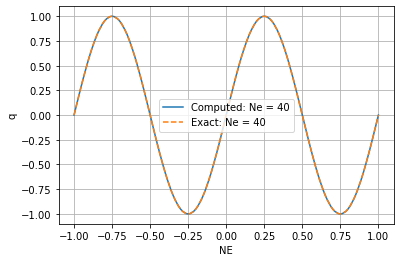

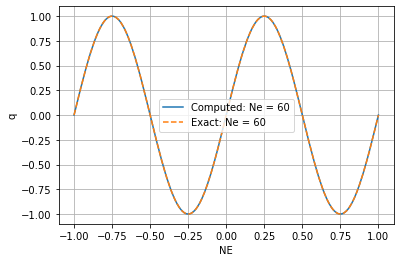

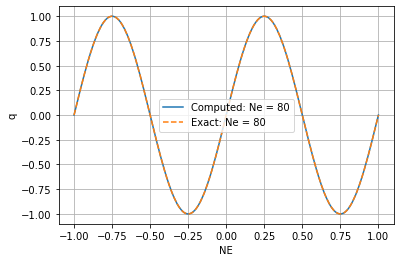

In [24]:
# list of the number of elements

NE = [40,60,80]
l = len(NE)

# array that contains the error for each iteration
Error = np.zeros(l)

for ne in range(l):
    
    Ne = NE[ne]
    Np = N*Ne+1
    
    # space stuff
    #x = np.linspace(-1, 1, Np)
    #x = np.array(Lobatto_p(Np-1))
    x=np.zeros(Np)
    xel=np.linspace(-1,1,Ne+1)
    xe2=np.array(Lobatto_p(N))
    xe=xe2[::-1]
    for e in range(1,Ne+1):
        a=xel[e-1] ; b=xel[e]
       
        xsi=((b-a)/2)*(xe-1) + b
        #print('a=',a)
        #print('b=',b)
        #print('xsi=',xsi)
        for i in range(0,N+1):
            ip=intma(e,N)[i]
            #print('ip=',ip)
            x[ip]=xsi[i]
    #x = np.linspace(-1, 1, Np)
    
    dx = (bx-ax)/(Np-1)   # for second order

    #time stuff

    dtest = a*dx/np.abs(u)
    M = Tf//dtest+1    # Number of time steps
    M = int(M)
    t = np.linspace(0, Tf, M+1)
    dt = Tf/M
    
    # approximate solution of the wave equation
    q = Solver_1DW(N,Ne,M,x,t,dt)
    
    # exact solution
    q_exact = qinit(x-u*t[M])
    #error
    error = np.abs(q-q_exact)
    Error[ne] = np.max(error)
    
    #plot of the computed and exact solutions
    
    plt.figure(ne)
    plt.plot(x, q, label = 'Computed: Ne = {}'.format(Ne))
    plt.plot(x, q_exact, '--', label = 'Exact: Ne = {}'.format(Ne))
    
    plt.xlabel('NE')
    plt.ylabel('q')
    plt.legend()
    plt.grid() 
    
    

In [16]:
x

array([-1.        , -0.98618034, -0.96381966, -0.95      , -0.93618034,
       -0.91381966, -0.9       , -0.88618034, -0.86381966, -0.85      ,
       -0.83618034, -0.81381966, -0.8       , -0.78618034, -0.76381966,
       -0.75      , -0.73618034, -0.71381966, -0.7       , -0.68618034,
       -0.66381966, -0.65      , -0.63618034, -0.61381966, -0.6       ,
       -0.58618034, -0.56381966, -0.55      , -0.53618034, -0.51381966,
       -0.5       , -0.48618034, -0.46381966, -0.45      , -0.43618034,
       -0.41381966, -0.4       , -0.38618034, -0.36381966, -0.35      ,
       -0.33618034, -0.31381966, -0.3       , -0.28618034, -0.26381966,
       -0.25      , -0.23618034, -0.21381966, -0.2       , -0.18618034,
       -0.16381966, -0.15      , -0.13618034, -0.11381966, -0.1       ,
       -0.08618034, -0.06381966, -0.05      , -0.03618034, -0.01381966,
        0.        ,  0.01381966,  0.03618034,  0.05      ,  0.06381966,
        0.08618034,  0.1       ,  0.11381966,  0.13618034,  0.15

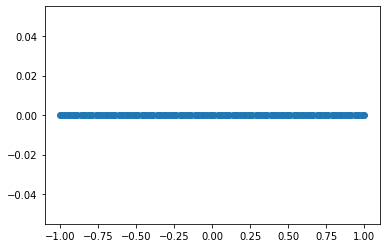

In [17]:
x
x1=np.zeros(len(x))
plt.plot(x,x1,'o')

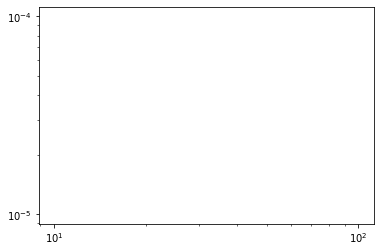

In [21]:
plt.loglog(NE, Error)
plt.show()

In [22]:
p = np.polyfit(np.log(NE), np.log(Error),1)
p

/home/brian/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


array([-1.48749999, -5.48720817])

In [23]:
Error

array([1.71345042e-05])